In [1]:
import math
import itertools
import numpy as np
from numba import njit

import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jit
from jax.config import config
config.update("jax_enable_x64", True)

from lcm.dag import concatenate_functions
from lcm.dispatchers import gridmap, productmap

from numpy.testing import assert_array_almost_equal as aaae

In [2]:
def plot_runtime(n_points, runtime_numba, runtime_jax, func="product_map"):
    plt.figure(figsize=[10, 6])
    plt.plot(n_points, [i * 1000 for i in runtime_numba], label="Numba")
    plt.plot(n_points, [i * 1000 for i in runtime_jax], label="JAX")

    plt.xlabel("Number of Grid Points")
    plt.ylabel("Runtime (in milliseconds)")
    plt.title(f"Runtime of hardcoded Numba function versus {func} with JAX")
    
    plt.legend()
    plt.show()

## product_map: 2 grids benchmark

In [3]:
def _utility(_consumption, _leisure):
    return _consumption + _leisure


def _leisure(working):
    return 24 - working


def _consumption(working, wage):
    return wage * working


def _unrelated(working):  # noqa: U100
    raise NotImplementedError()

In [4]:
@njit(fastmath=True)
def product_map_numba_2d(wage, working):
    n_wage = wage.shape[0]
    n_working = working.shape[0]

    cross_product = np.empty((n_wage, n_working))

    for i in range(n_wage):
        for j in range(n_working):
            cross_product[i, j] = wage[i] * working[j] + (24 - working[j])

    return cross_product

In [6]:
grids = {
    "wage": jnp.linspace(1, 10, 101),
    "working": jnp.linspace(0, 24, 25),
}

wage = np.linspace(1, 10, 101)
working = np.linspace(0, 24, 25)

utility_concat = concatenate_functions(
    functions=[_utility, _unrelated, _leisure, _consumption], targets="_utility"
)
_decorated_func = productmap(utility_concat, ["wage", "working"])
decorated_func_jit = jit(_decorated_func)
rslt_jax = decorated_func_jit(**grids)

rslt_numba = product_map_numba_2d(wage, working)

aaae(rslt_jax, rslt_numba)

In [10]:
def get_numba_runtime_2d():        
    total_points = []
    runtime = []
    
    for len_grid in grid_space:
        total_points.append(len_grid**2)
        
        grids = {
            "wage": np.linspace(1, 10, len_grid),
            "working": np.linspace(0, 24, len_grid),
        }
        
        product_map_numba_2d(**grids)
            
        timeit_res = %timeit -r 7 -n 1_000 -o product_map_numba_2d(**grids)
        runtime.append(timeit_res.average)

    return total_points, runtime

def get_jax_runtime_2d():
    utility_concat = concatenate_functions(
    functions=[_utility, _unrelated, _leisure, _consumption],
    targets="_utility"
    )
    _decorated_func = productmap(utility_concat, ["wage", "working"])
    decorated_func_jit = jit(_decorated_func)
        
    total_points = []
    runtime = []
    
    for len_grid in grid_space:
        total_points.append(len_grid**2)
        
        grids = {
            "wage": jnp.linspace(1, 10, len_grid),
            "working": jnp.linspace(0, 24, len_grid),
        }
    
        decorated_func_jit(**grids)
        
        timeit_res = %timeit -r 7 -n 1_000 -o decorated_func_jit(**grids).block_until_ready()
        runtime.append(timeit_res.average)

    return total_points, runtime

grid_space = [10, 25, 50] + np.arange(100, 1100, 100).tolist()

In [11]:
n_points_2_grids, runtime_numba_2d = get_numba_runtime_2d()

The slowest run took 4.78 times longer than the fastest. This could mean that an intermediate result is being cached.
893 ns ± 587 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
562 ns ± 5.37 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
818 ns ± 82.4 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.52 µs ± 73.2 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.26 µs ± 39 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.36 µs ± 55.7 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
20 µs ± 146 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
41.5 µs ± 519 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
61 µs ± 745 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
82.8 µs ± 711 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
107 µs ± 550 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
135 µs ± 702 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
169 µs ± 1.8 µs per loop

In [12]:
_, runtime_jax_2d = get_jax_runtime_2d()

2.46 µs ± 64.6 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.65 µs ± 6.31 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.1 µs ± 134 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.88 µs ± 16.4 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.27 µs ± 33.8 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
17.7 µs ± 56.3 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
21.3 µs ± 858 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
28.2 µs ± 616 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
35.3 µs ± 1.01 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
49.8 µs ± 3.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
45.3 µs ± 1.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
63.4 µs ± 2.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
58.8 µs ± 953 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


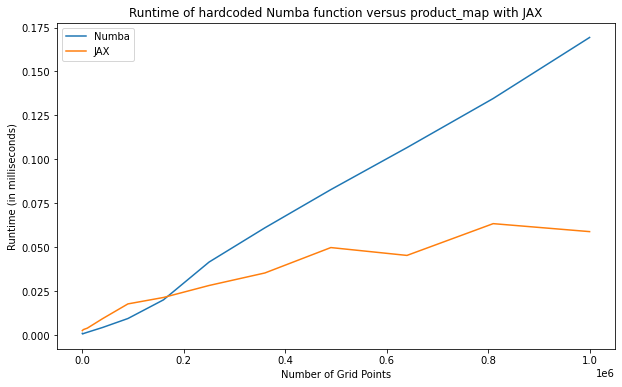

In [13]:
plot_runtime(n_points_2_grids, runtime_numba_2d, runtime_jax_2d)

## *product_map*: 4 grids benchmark

In [14]:
def _utility_4d(_consumption_4d, _leisure_4d):
    return _consumption_4d + _leisure_4d


def _leisure_4d(d):
    return jnp.cos(d)


def _consumption_4d(a, b, c):
    return jnp.log(a) + jnp.sqrt(jnp.square(b) * c)


@njit(fastmath=True)
def product_map_numba_4d(a, b, c, d):
    n_a = a.shape[0]
    n_b = b.shape[0]
    n_c = c.shape[0]
    n_d = d.shape[0]

    cross_product = np.empty((n_a, n_b, n_c, n_d))

    for i in range(n_a):
        for j in range(n_b):
            for k in range(n_c):
                for l in range(n_d):
                    cross_product[i, j, k, l] = (
                        np.log(a[i]) + np.sqrt(b[j] ** 2 * c[k]) + np.cos(d[l])
                    )

    return cross_product

In [16]:
grids = {
    "a": jnp.linspace(1, 10, 101),
    "b": jnp.linspace(0, 24, 25),
    "c": jnp.linspace(1, 5, 5),
    "d": jnp.linspace(-7, 2, 10)
}

a = np.linspace(1, 10, 101)
b = np.linspace(0, 24, 25)
c = np.linspace(1, 5, 5)
d = np.linspace(-7, 2, 10)

utility_concat_4d = concatenate_functions(
    functions=[_utility_4d, _leisure_4d, _consumption_4d, _unrelated,],
    targets="_utility_4d"
)
    
_decorated_func = productmap(utility_concat_4d , ["a", "b", "c", "d"])
decorated_func_jit = jit(_decorated_func)  
rslt_jax = decorated_func_jit(**grids)

rslt_numba = product_map_numba_4d(a, b, c, d)

aaae(rslt_jax, rslt_numba)

In [17]:
def get_numba_runtime_4d(len_grids_arr):
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        a = np.linspace(1, 10, len_a)
        b = np.linspace(0, 24, len_b)
        c = np.linspace(1, 5, len_c)
        d = np.linspace(-7, 2, len_d)
    
        product_map_numba_4d(a, b, c, d)
        
        timeit_res = %timeit -r 7 -n 1_000 -o product_map_numba_4d(a, b, c, d)
        runtime.append(timeit_res.average)

    return total_points, runtime


def get_jax_runtime_4d(len_grids_arr):
    utility_concat_4d = concatenate_functions(
    functions=[_utility_4d, _leisure_4d, _consumption_4d, _unrelated,],
    targets="_utility_4d"
    )
    
    _decorated_func = productmap(utility_concat_4d , ["a", "b", "c", "d"])
    decorated_func_jit = jit(_decorated_func)    
    
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        grids = {
            "a": jnp.linspace(1, 10, len_a),
            "b": jnp.linspace(0, 24, len_b),
            "c": jnp.linspace(1, 5, len_c),
            "d": jnp.linspace(-7, 2, len_d)
        }
    
        decorated_func_jit(**grids)
        
        timeit_res = %timeit -r 7 -n 1_000 -o decorated_func_jit(**grids).block_until_ready()
        runtime.append(timeit_res.average)

    return total_points, runtime

len_grids_arr = np.vstack((
    [5, 10, 20, 60, 100],
    np.linspace(5, 25, 5),
    np.linspace(1, 5, 5),
    np.linspace(2, 10, 5),
))

In [18]:
n_points_4d, runtime_numba_4d = get_numba_runtime_4d(len_grids_arr)

1.72 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.79 µs ± 358 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
57.4 µs ± 203 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
419 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.39 ms ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
_, runtime_jax_4d = get_jax_runtime_4d(len_grids_arr)

3.07 µs ± 27.9 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.27 µs ± 11.2 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.01 µs ± 12.3 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.94 µs ± 103 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
17.7 µs ± 3.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


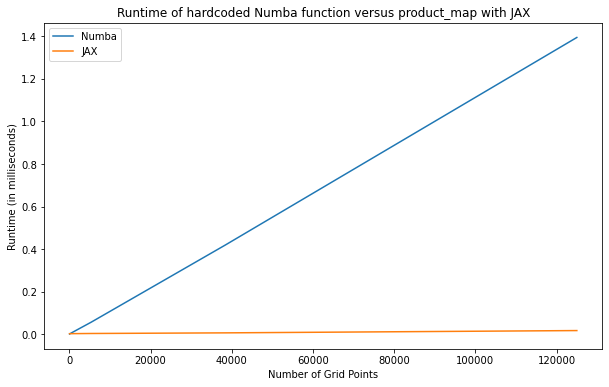

In [21]:
plot_runtime(n_points_4d, runtime_numba_4d, runtime_jax_4d)

## *gridmap*: 4 grids benchmark

In [22]:
@njit(fastmath=True)
def state_space_map_numba(a, b, c, d):
    n_a = a.shape[0]
    n_b = b.shape[0]
    n_c = c.shape[0]

    state_space_product = np.empty((n_a, n_b, n_c))

    for i in range(n_a):
        for j in range(n_b):
            for k in range(n_c):
                state_space_product[i, j, k] = (
                    np.log(a[i]) + np.sqrt(b[j] ** 2 * c[k]) + np.cos(d[k])
                )

    return state_space_product

In [23]:
# JAX
simple_variables = {
    "a": jnp.linspace(1, 10, 101),
    "b": jnp.linspace(0, 24, 25),
}
complex_grids = {
    "c": jnp.linspace(1, 5, 5),
    "d": jnp.linspace(-7, 2, 10)
}
helper = jnp.array(list(itertools.product(*complex_grids.values()))).T

complex_variables = {
    "c": helper[0],
    "d": helper[1],
}

# Numpy
simple_variables_numpy = {
    "a": np.linspace(1, 10, 101),
    "b": np.linspace(0, 24, 25),
}
complex_grids_numpy = {
    "c": np.linspace(1, 5, 5),
    "d": np.linspace(-7, 2, 10)
}
helper = np.array(list(itertools.product(*complex_grids_numpy.values()))).T

complex_variables_numpy = {
    "c": helper[0],
    "d": helper[1],
}
all_grids = {**simple_variables_numpy, **complex_variables_numpy}

In [25]:
utility_concat_4d = concatenate_functions(
    functions=[
        _utility_4d,
        _leisure_4d,
        _consumption_4d,
        _unrelated,
    ],
    targets="_utility_4d",
)

_decorated_func = gridmap(
    utility_concat_4d, list(simple_variables), list(complex_variables)
)
decorated_func_jit = jit(_decorated_func)
rslt_jax = decorated_func_jit(**simple_variables, **complex_variables)

rslt_numba = state_space_map_numba(*all_grids.values())

aaae(rslt_jax, rslt_numba)

In [26]:
def get_numba_runtime(len_grids_arr):
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        simple_variables = {
            "a": np.linspace(1, 10, len_a),
            "b": np.linspace(0, 24, len_b),
        }
        complex_grids = {
            "c": np.linspace(1, 5, len_c),
            "d": np.linspace(-7, 2, len_d)
        }
        helper = np.array(list(itertools.product(*complex_grids.values()))).T

        complex_variables = {
            "c": helper[0],
            "d": helper[1],
        }
        all_grids = {**simple_variables, **complex_variables}
    
        state_space_map_numba(*all_grids.values())
        
        timeit_res = %timeit -r 7 -n 1_000 -o state_space_map_numba(*all_grids.values())
        runtime.append(timeit_res.average)

    return total_points, runtime


def get_jax_runtime(len_grids_arr):
    utility_concat_4d = concatenate_functions(
    functions=[_utility_4d, _leisure_4d, _consumption_4d, _unrelated,],
    targets="_utility_4d"
    )
    
    _decorated_func = gridmap(utility_concat_4d , ["a", "b"], ["c", "d"])
    decorated_func_jit = jit(_decorated_func)    
    
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        simple_variables = {
            "a": jnp.linspace(1, 10, len_a),
            "b": jnp.linspace(0, 24, len_b),
        }
        complex_grids = {
            "c": jnp.linspace(1, 5, len_c),
            "d": jnp.linspace(-7, 2, len_d)
        }
        helper = jnp.array(list(itertools.product(*complex_grids.values()))).T

        complex_variables = {
            "c": helper[0],
            "d": helper[1],
        }
    
        decorated_func_jit(**simple_variables, **complex_variables)
        
        timeit_res = %timeit -r 7 -n 1_000 -o decorated_func_jit(**simple_variables, **complex_variables).block_until_ready()
        runtime.append(timeit_res.average)

    return total_points, runtime

In [27]:
n_points, runtime_numba = get_numba_runtime(len_grids_arr)

1.24 µs ± 88.6 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
10.1 µs ± 360 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
59.7 µs ± 173 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
436 µs ± 456 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.42 ms ± 1.21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [28]:
_, runtime_jax = get_jax_runtime(len_grids_arr)

3.42 µs ± 32.4 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.47 µs ± 10.1 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.44 µs ± 25.2 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
8 µs ± 43.7 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
21.2 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


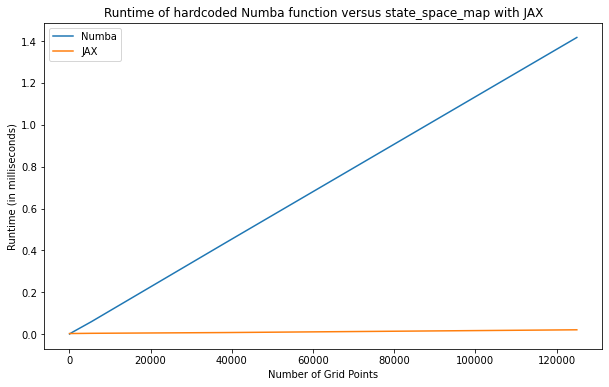

In [29]:
plot_runtime(n_points, runtime_numba, runtime_jax, func="state_space_map")

## 4d Benchmark with multiple targets and product_map

In [30]:
def _utility_4d(_consumption_4d, _leisure_4d):
    return _consumption_4d + _leisure_4d


def _leisure_4d(d):
    return jnp.cos(d)


def _consumption_4d(a, b, c):
    return jnp.log(a) + jnp.sqrt(jnp.square(b) * c)


@njit(fastmath=True)
def product_map_numba_4d(a, b, c, d):
    n_a = a.shape[0]
    n_b = b.shape[0]
    n_c = c.shape[0]
    n_d = d.shape[0]

    out_utility = np.empty((n_a, n_b, n_c, n_d))
    out_leisure = np.empty((n_a, n_b, n_c, n_d))
    
    for i in range(n_a):
        for j in range(n_b):
            for k in range(n_c):
                for l in range(n_d):
                    _leis = np.cos(d[l])
                    
                    out_leisure[i, j, k, l] = _leis
                    out_utility[i, j, k, l] = (
                        np.log(a[i]) + np.sqrt(b[j] ** 2 * c[k]) + _leis
                    )

    return out_leisure, out_utility

In [32]:
grids = {
    "a": jnp.linspace(1, 10, 101),
    "b": jnp.linspace(0, 24, 25),
    "c": jnp.linspace(1, 5, 5),
    "d": jnp.linspace(-7, 2, 10)
}

a = np.linspace(1, 10, 101)
b = np.linspace(0, 24, 25)
c = np.linspace(1, 5, 5)
d = np.linspace(-7, 2, 10)

utility_concat_4d = concatenate_functions(
    functions=[_utility_4d, _leisure_4d, _consumption_4d, _unrelated,],
    targets=["_leisure_4d", "_utility_4d"]
)
    
_decorated_func = productmap(utility_concat_4d , ["a", "b", "c", "d"])
decorated_func_jit = jit(_decorated_func)  
rslt_jax = decorated_func_jit(**grids)

rslt_numba = product_map_numba_4d(a, b, c, d)

aaae(rslt_jax, rslt_numba)

In [33]:
def get_numba_runtime_4d(len_grids_arr):
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        a = np.linspace(1, 10, len_a)
        b = np.linspace(0, 24, len_b)
        c = np.linspace(1, 5, len_c)
        d = np.linspace(-7, 2, len_d)
    
        product_map_numba_4d(a, b, c, d)
        
        timeit_res = %timeit -r 7 -n 1_000 -o product_map_numba_4d(a, b, c, d)
        runtime.append(timeit_res.average)

    return total_points, runtime


def get_jax_runtime_4d(len_grids_arr):
    utility_concat_4d = concatenate_functions(
    functions=[_utility_4d, _leisure_4d, _consumption_4d, _unrelated,],
    targets="_utility_4d"
    )
    
    _decorated_func = productmap(utility_concat_4d , ["a", "b", "c", "d"])
    decorated_func_jit = jit(_decorated_func)    
    
    total_points = []
    runtime = []
    
    for len_grids in len_grids_arr.T:
        len_a, len_b, len_c, len_d = len_grids.astype(int)
        total_points.append(math.prod(len_grids))
        
        grids = {
            "a": jnp.linspace(1, 10, len_a),
            "b": jnp.linspace(0, 24, len_b),
            "c": jnp.linspace(1, 5, len_c),
            "d": jnp.linspace(-7, 2, len_d)
        }
    
        decorated_func_jit(**grids)
        
        timeit_res = %timeit -r 7 -n 1_000 -o decorated_func_jit(**grids).block_until_ready()
        runtime.append(timeit_res.average)

    return total_points, runtime

len_grids_arr = np.vstack((
    [5, 10, 20, 60, 100],
    np.linspace(5, 25, 5),
    np.linspace(1, 5, 5),
    np.linspace(2, 10, 5),
))

In [34]:
n_points_4d, runtime_numba_4d = get_numba_runtime_4d(len_grids_arr)

1.7 µs ± 435 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
10.3 µs ± 211 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
59.4 µs ± 216 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
436 µs ± 569 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.42 ms ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
_, runtime_jax_4d = get_jax_runtime_4d(len_grids_arr)

3.12 µs ± 79.6 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.31 µs ± 14.6 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.04 µs ± 78.6 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.96 µs ± 27 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
21.4 µs ± 595 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


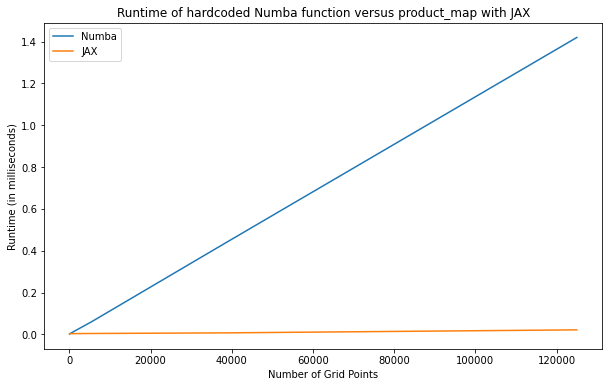

In [36]:
plot_runtime(n_points_4d, runtime_numba_4d, runtime_jax_4d)